In [57]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import networkx as nx
import tqdm
from functools import cached_property
from math import lcm, gcd

I want to consider the following transformation. Given a number $n$, it can be written as a list of digits:

$$ n = [n_{k}n_{k-1}\ldots n_{2}n_{1}] $$


The transformation consists in dropping the lowest digit and shifting the remaining digits to the right, and then adding a multiple of the dropped digit to the result:

$$ [n_{k}n_{k-1}\ldots n_{2}n_{1}] \mapsto [n_{k}n_{k-1}\ldots n_{2}] + r n_1 $$

where $r$ is a constant.

We'll start with 2-digit numbers $ n = [ab] $, so $$ f_r([ab]) = a + r b $$.

We want to discover: for how many numbers $[ab] = f_r([ab])$?

Text(0.5, 1.0, '$f([ab] = f_r([ab])$')

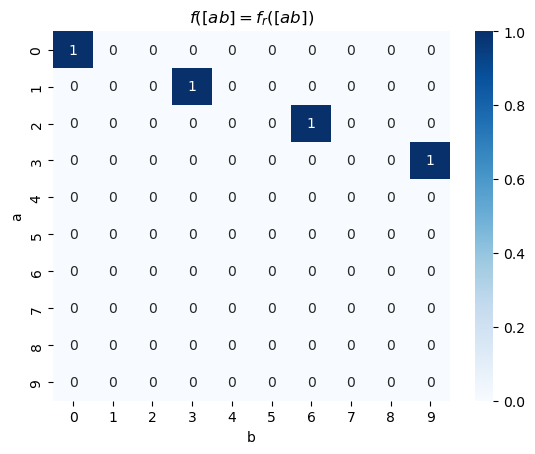

In [4]:
a = np.arange(0, 10)
b = np.arange(0, 10)

original_numbers = a[:, None] * 10 + b[None, :]
transformed_numbers = a[:, None] + 4 * b[None, :]
ax = sns.heatmap(original_numbers == transformed_numbers, cmap="Blues", annot=True)
ax.set_xlabel("b")
ax.set_ylabel("a")
ax.set_title(r"$f([ab] = f_r([ab])$")

So, for $r=4$, we have four possibilities: 0, 13, 26 and 39. Let's calculate $\phi(r)$ = the number of solutions for $r$. That is:

$$\phi(r) = \sum_{a=0}^9\sum_{b=0}^9 \mathbb{1}_{f_r([ab]) = [ab]}$$

where $\mathbb{1}_{\text{condition}}$ is the indicator function, equal to 1 if the condition is true, and 0 otherwise.


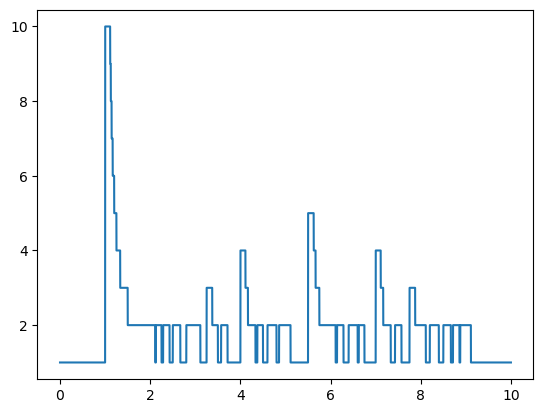

In [5]:
def num_solutions(r):
    original_numbers = a[:, None] * 10 + b[None, :]
    transformed_numbers = (a[:, None] + r * b[None, :]).astype(int)
    return np.sum(original_numbers == transformed_numbers)


xs = np.arange(0, 10, 0.0001)
ys = np.array([num_solutions(r) for r in xs])

plt.plot(xs, ys)

Now lets try 3 digit numbers $n = [abc]$. We have:

In [6]:
a = np.arange(10)
b = np.arange(10)
c = np.arange(10)

def num_solutions(r):
    original_numbers = a[:, None, None] * 100 + b[None, :, None] * 10 + c[None, None, :]
    transformed_numbers = (a[:, None, None] * 10 + b[None, :, None] + r * c[None, None, :]).astype(int)
    return np.sum(original_numbers == transformed_numbers)

Text(0.5, 1.0, 'Number of solutions for r in [1, 1000]')

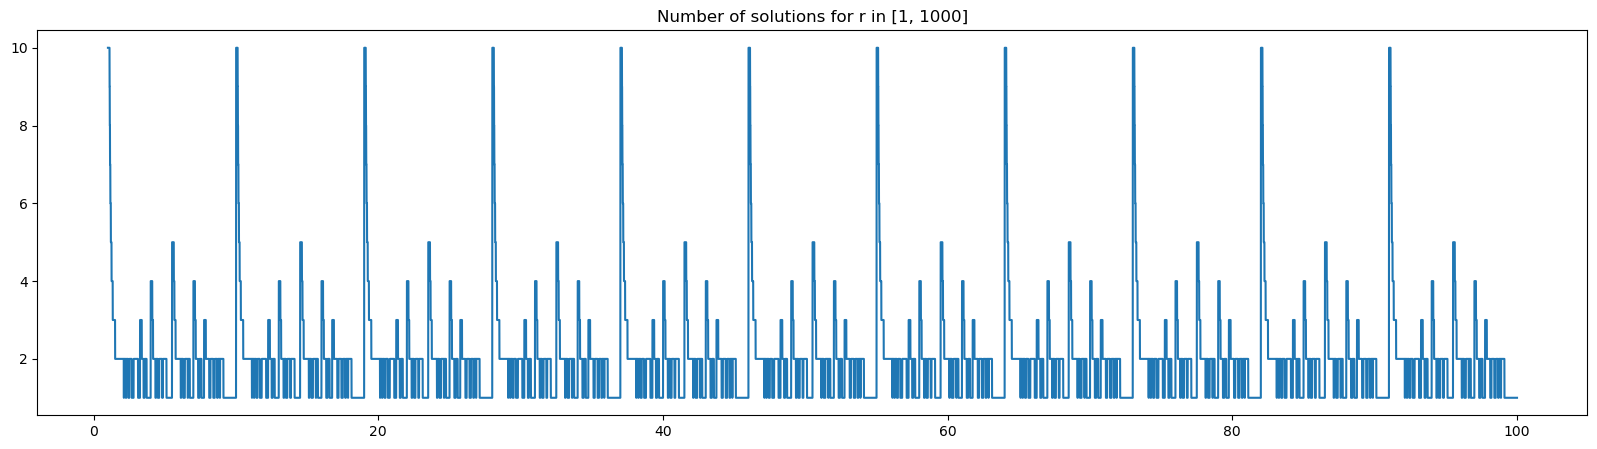

In [7]:
xs = np.arange(1, 100, 0.001)
ys = np.array([num_solutions(r) for r in xs])

plt.figure(figsize=(20, 5))
plt.plot(xs, ys)
plt.title("Number of solutions for r in [1, 1000]")

Let's explore orbits of this transformation.

In [214]:
def transformation(x, r):
    last_digit = x % 10
    rest = x // 10
    return int(rest + r * last_digit)

def repeated_application(function, x, r):
    output = [x]
    new_value = function(output[-1], r)
    while new_value not in output:
        output.append(new_value)
        new_value = function(output[-1], r)
    output.append(new_value)
    return output

def build_graph(function, starting_points, r):
    g = nx.Graph()
    for x in tqdm.tqdm(starting_points, desc="building graph..."):
        orbit = repeated_application(function, x, r)
        g.add_nodes_from(sorted(set(orbit)))
        g.add_edges_from(zip(orbit, orbit[1:]))
    return g
        

In [215]:
repeated_application(transformation, 299, 0.2)

[299, 30, 3, 0, 0]

In [216]:
def get_subgraphs(g):
    connected_components = nx.connected_components(g)
    for node_set in connected_components:
        yield g.subgraph(node_set)


def draw_graph(g, ax):
    initial_positions = nx.spectral_layout(g)
    pos = nx.spring_layout(g, k=0.01, pos=initial_positions, iterations=100, seed=129037)
    nx.draw(g, pos, node_size=10, with_labels=False, ax=ax)

In [217]:
class GraphPlotPlan:
    
    def __init__(self):
        self.graphs = {}
        self.num_components = set()
    
    def add_to_plan(self, title, graph):
        self.graphs[title] = graph
        self.num_components.add(nx.number_connected_components(graph))

    def plot(self, figsize=(2, 2), fontsize=2):
        height = len(self.graphs)
        width = lcm(*self.num_components)
        factor = gcd(width, height)
        fig = plt.figure(figsize=(figsize[0] * width // factor, figsize[1] * height // factor))
        grid = fig.add_gridspec(height, width)
        
        for i, (title, graph) in enumerate(tqdm.tqdm(self.graphs.items(), desc="plotting...")):
            num_plots = nx.number_connected_components(graph)
            subplot_width = width // num_plots
            for j, subgraph in enumerate(get_subgraphs(graph)):
                ax = fig.add_subplot(grid[i, (j * subplot_width):(j + 1) * subplot_width])
                draw_graph(subgraph, ax=ax)
                ax.set_title(f"{title}, {j + 1}-th", fontsize=fontsize)
        fig.tight_layout()

In [218]:
def iterate_graphs(function, starting_points, rs):
    last_graph = None
    for r in tqdm.tqdm(rs):
        current_graph = build_graph(function, starting_points, r)
        if (last_graph is None) or not (nx.is_isomorphic(last_graph, current_graph)): 
            yield r, current_graph
        last_graph = current_graph

plotting...: 100%|██████████| 61/61 [00:01<00:00, 37.25it/s]
/var/folders/s6/w2v5p3l12nv4jz0cy2bqmqq00000gn/T/ipykernel_37536/3356601171.py:25: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  fig.tight_layout()


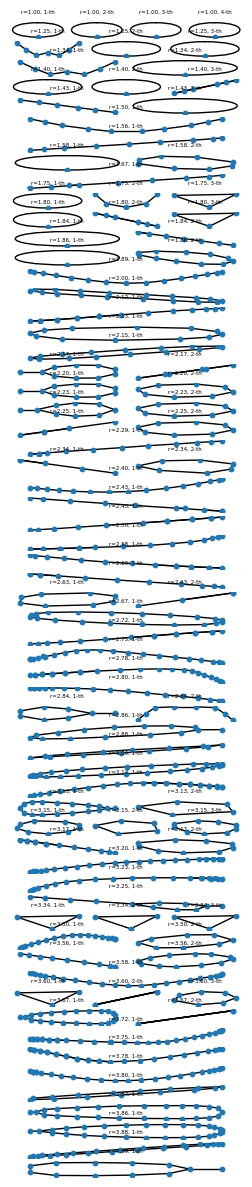

In [219]:
plot_plan = GraphPlotPlan()
for (r, graph) in iterate_graphs(transformation, [1, 2, 3, 4], np.arange(1, 4, 0.01)):
    plot_plan.add_to_plan(f"r={r:1.2f}", graph)
    
plot_plan.plot((0.3, 0.25), fontsize=4)

plotting...: 100%|██████████| 1/1 [00:00<00:00,  5.65it/s]


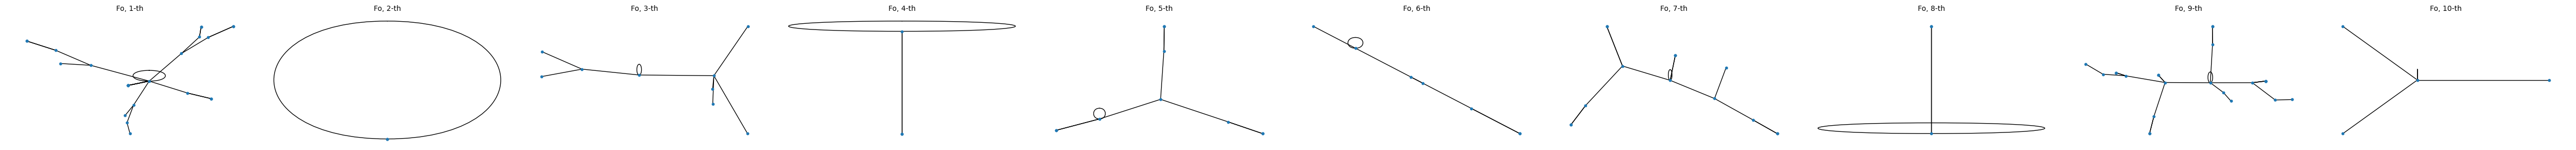

In [225]:
function = lambda x, r: int(np.prod([float(k) + r for k in str(x)]))
plot_plan = GraphPlotPlan()
plot_plan.add_to_plan("Fo", build_graph(function, range(100), 0))
plot_plan.plot(figsize=(5, 3), fontsize=10)

plotting...: 100%|██████████| 5/5 [00:01<00:00,  3.80it/s]


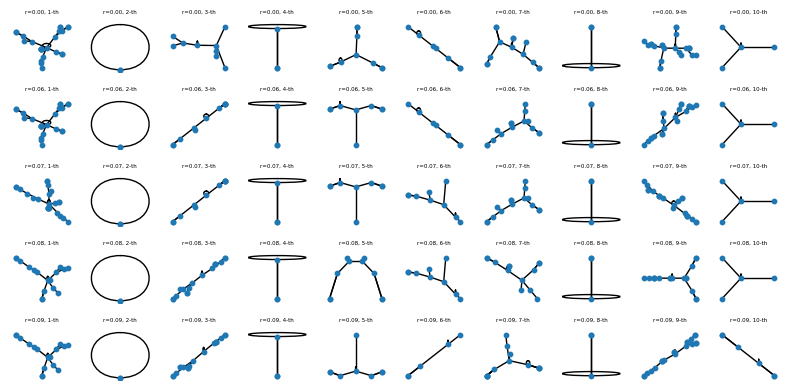

In [228]:
plot_plan = GraphPlotPlan()
for (r, graph) in iterate_graphs(function, range(100), np.arange(0, 0.1, 0.01)):
    plot_plan.add_to_plan(f"r={r:1.2f}", graph)
    
plot_plan.plot((4, 4), fontsize=4)

110.0